# Ambiente python utilizado

In [4]:
from platform import python_version
python_version()

'3.9.13'

# Ambient virtual utilizado no notebook

![Ambiente virtual conda](env_prof.png)

# Libs do Ambiente Virtual

In [251]:
conda list

# packages in environment at /Users/walterpereira/opt/anaconda3/envs/cluster_env:
#
# Name                    Version                   Build  Channel
anyio                     3.5.0            py39hecd8cb5_0  
appnope                   0.1.2           py39hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py39hca72f7f_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
attrs                     21.4.0             pyhd3eb1b0_0  
babel                     2.9.1              pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.11.1           py39hecd8cb5_0  
blas                      1.0                         mkl  
bleach                    4.1.0              pyhd3eb1b0_0  
bottleneck                1.3.5            py39h67323c0_0  
brotli                    1.0.9                hca72f7f_7  
brotli-bin                1.0.9                hca72f7f_7  
brotlip

# Geração requeriments.txt 

In [252]:
conda list --export > requirements.txt


Note: you may need to restart the kernel to use updated packages.


# Ambiente Utilizado

![Ambiente virtual conda](env_prof_2.png)

# Base de dados e justificativa

A base escolhida é a do instituto nacional de diabetes e problemas renais, disponível no [kagle](https://www.kaggle.com/datasets/whenamancodes/predict-diabities). O objetivo do trabalho é tentar gerar um algoritomo de classificação que indica pacientes que possuem diabetes, não possuem e possiveis graus de perigo de acordo com a quantidade de clusters a serem criados, seguindo os métodos de otimização solicitado pelo projeto.

In [81]:
import numpy as np
import pandas as pd
from pivottablejs import pivot_ui
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA 
%matplotlib inline
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import metrics

def plot_cluster_points(df, labels, ax=None, hue="cluster", legend="auto"):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cluster'] = pd.Categorical(labels)
    sns.scatterplot(x="PC1", y="PC2", hue=hue, data=pca_data, ax=ax, legend=legend)

# Analisa dos dados

In [10]:
diabetes_df = pd.read_csv('diabetes.csv')

In [28]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [23]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


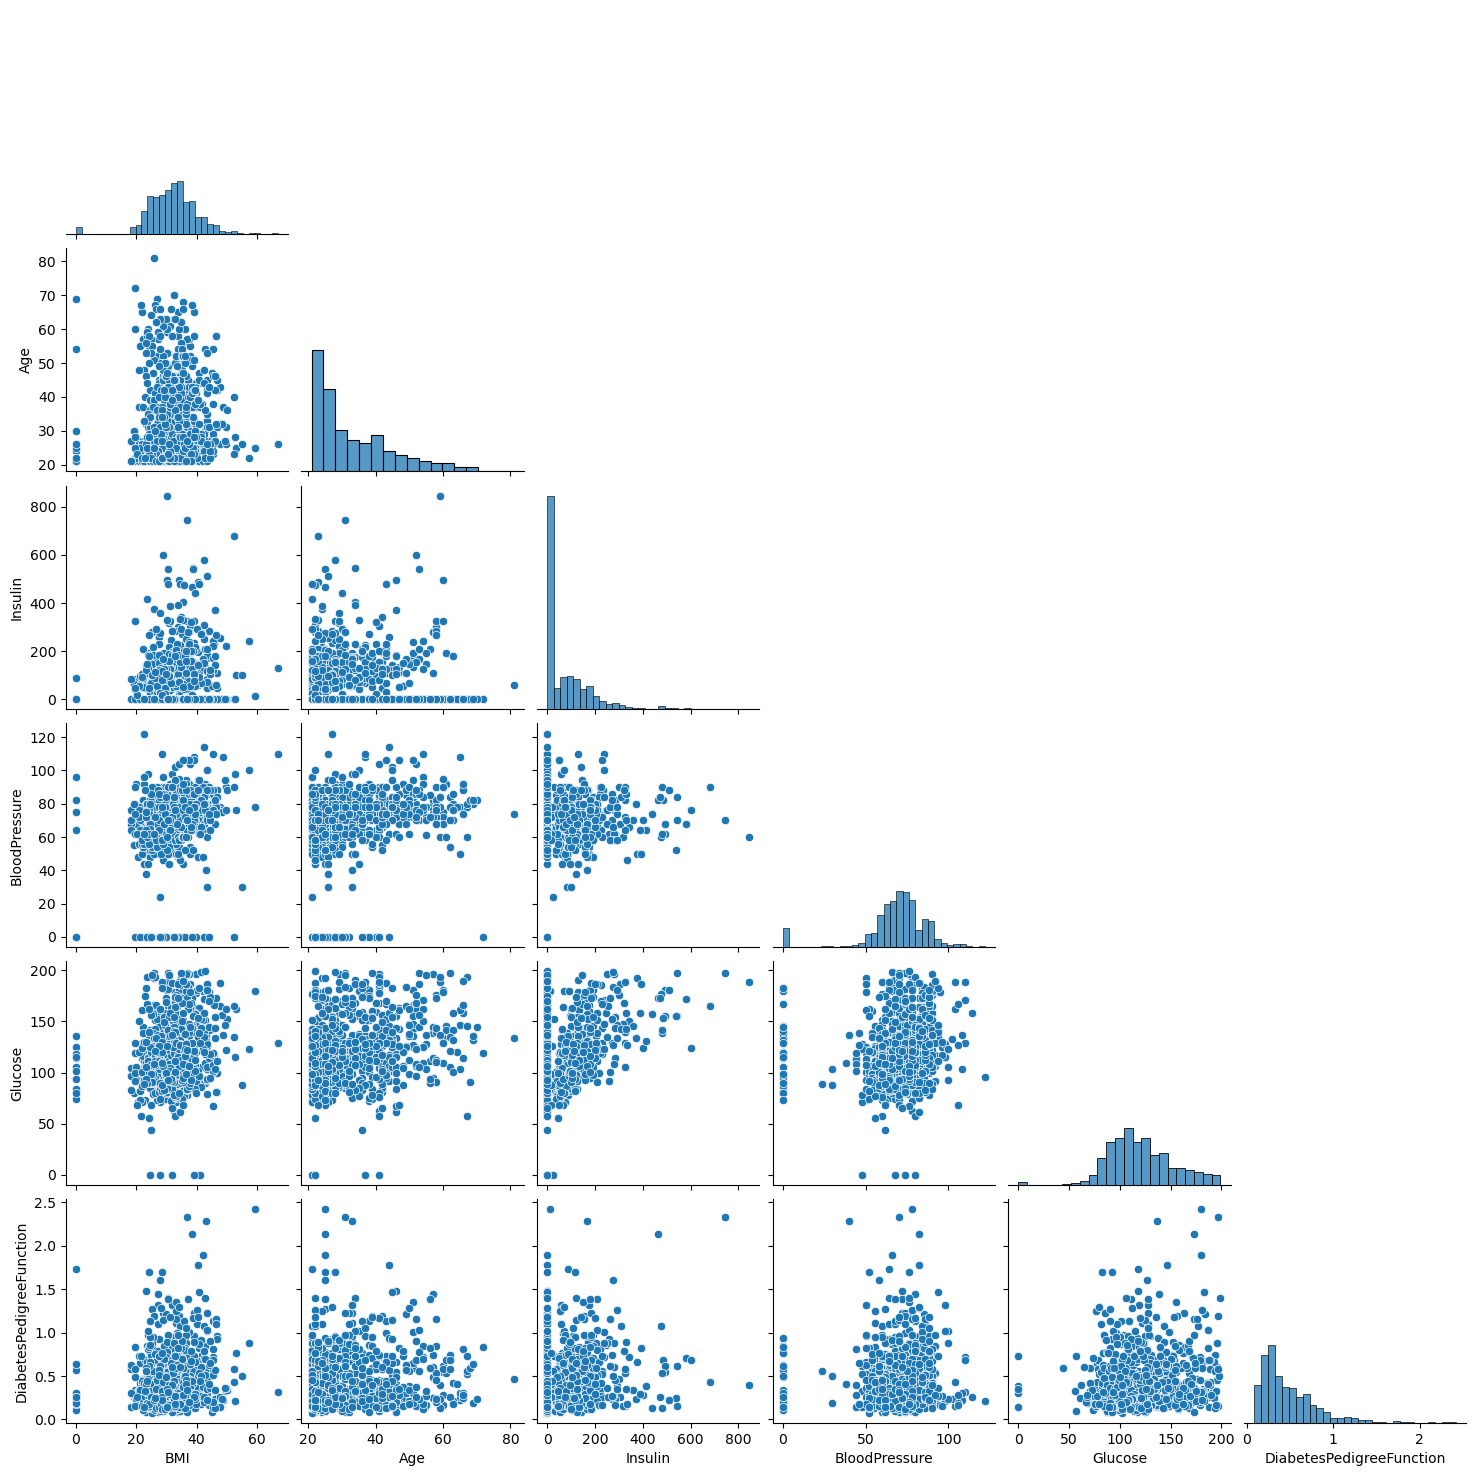

In [53]:
_ = sns.pairplot(diabetes_df.loc[:,['BMI','Age','Insulin','BloodPressure','Glucose','DiabetesPedigreeFunction']],corner=True,)

Os dados possuem outliers para algumas features. Antes da clusterização estes deverão ser removidos, inclusive o preprocessamento também será realizado antes da proxima etápa.
Como a base não possui dado categórico, apenas a padronização de valores será necessária, logo todos terão o mesmo peso no processo de clusterização. <br>
Para a Feature **Insulin** os valores zerados não serão descartados, pois a quantidade mínima de insulina no sangue é de 0.5ml, o que pode caracterizar valores zerados como de erro na medição.

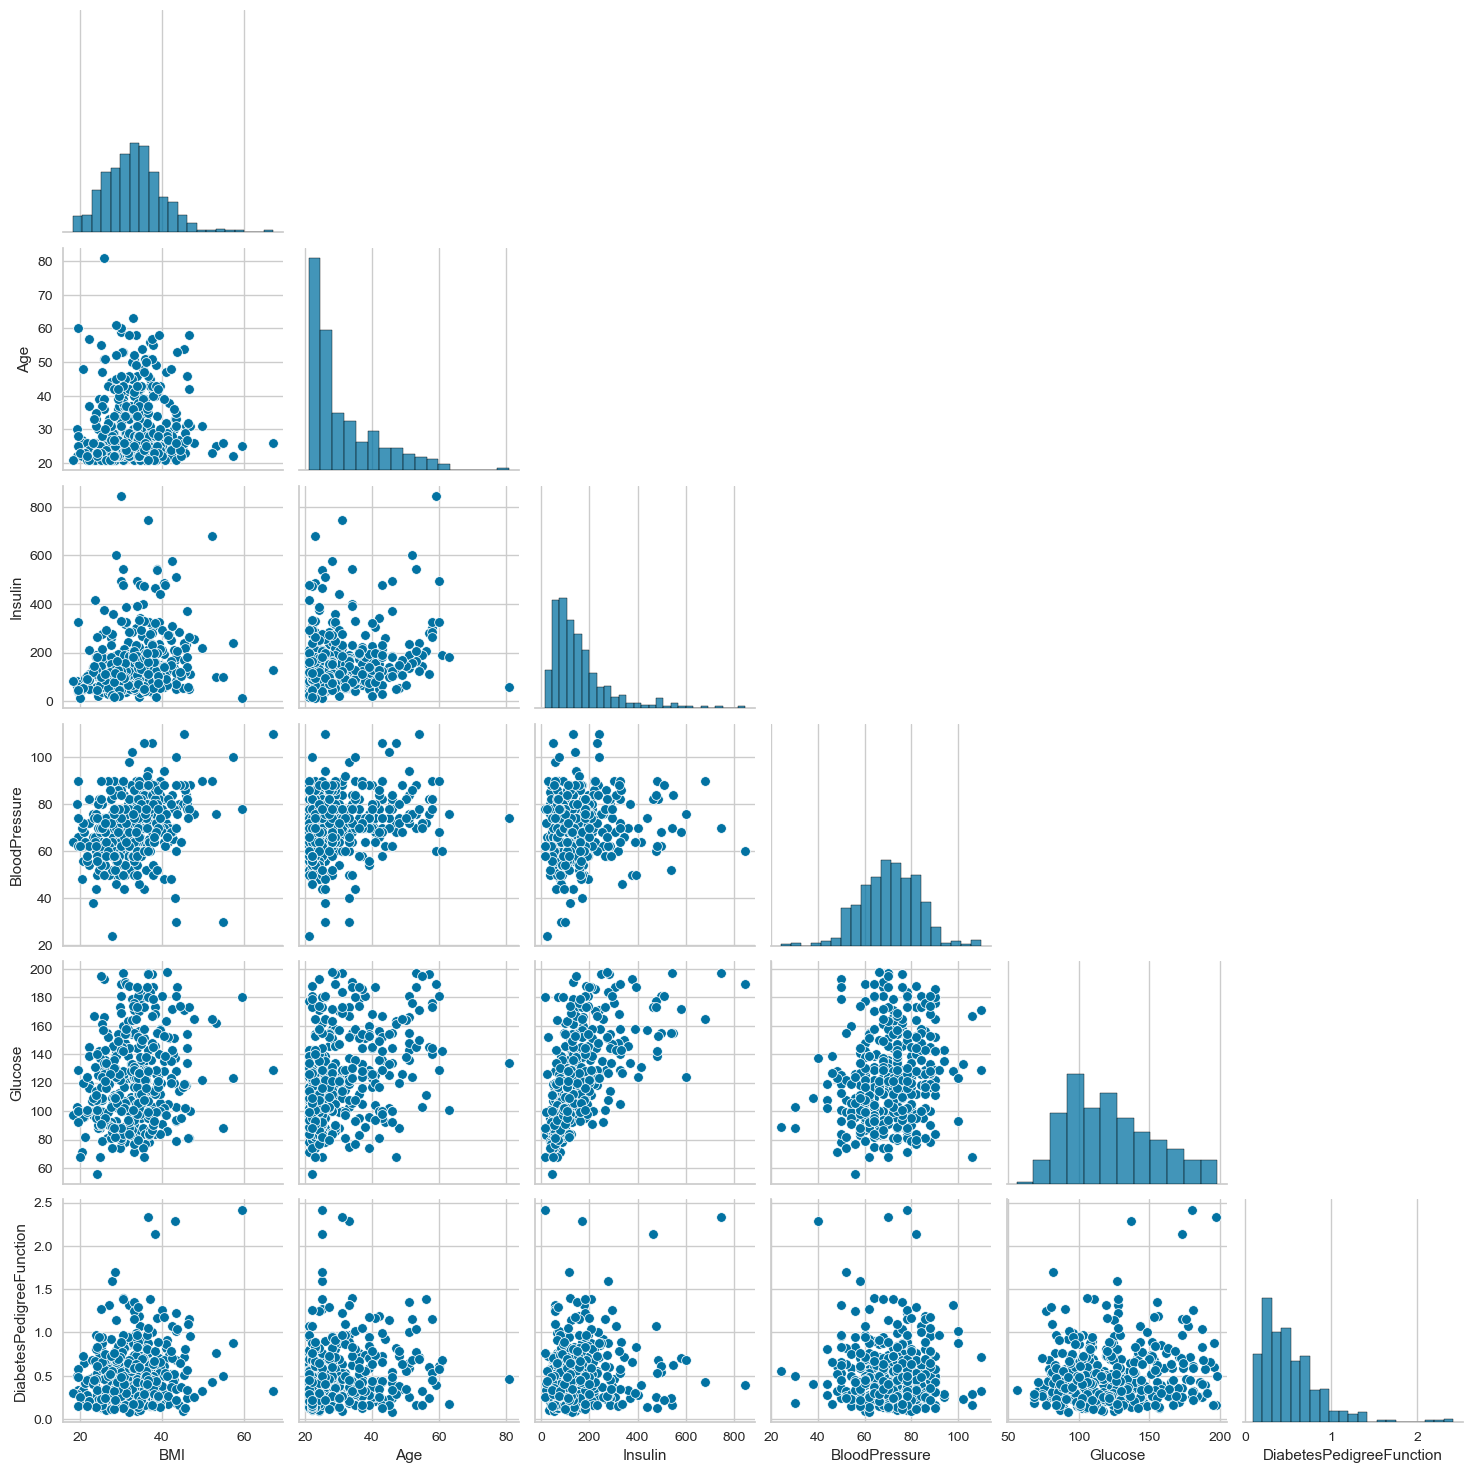

In [11]:
diabetes_filtred_df = diabetes_df[(diabetes_df.Glucose != 0) & (diabetes_df.BloodPressure != 0) & 
                                  (diabetes_df.BMI != 0) & (diabetes_df.Insulin != 0) ]
_ = sns.pairplot(diabetes_filtred_df.loc[:,['BMI','Age','Insulin','BloodPressure','Glucose','DiabetesPedigreeFunction']],
                 corner=True,)

Para a padronização será usada o StandarScaler disponível no framework sklearn

In [14]:
from sklearn.preprocessing import StandardScaler

In [23]:
stand_esc = StandardScaler()
column_list = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
stand_esc.fit(diabetes_filtred_df[column_list])
diabetes_stand = stand_esc.transform(diabetes_filtred_df[column_list])
diabetes_stand_df = pd.DataFrame(diabetes_stand,columns=column_list)

# Agrupamento de Dados

### Silhueta

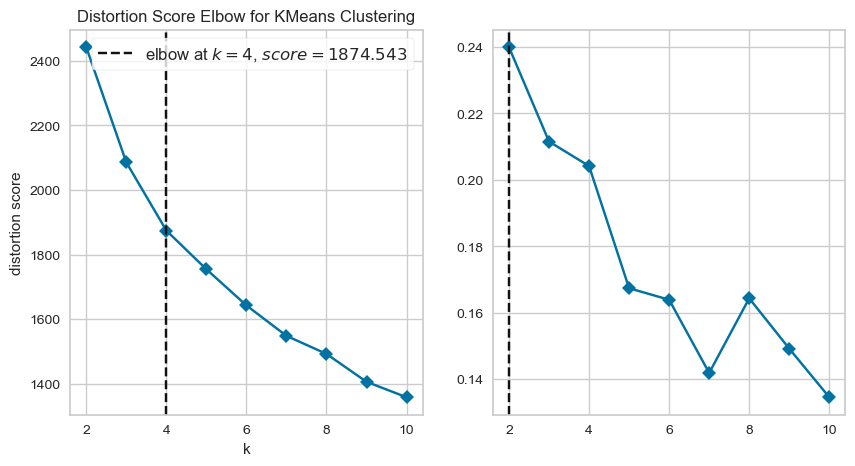

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [79]:
from yellowbrick.cluster import KElbowVisualizer
km = KMeans()

fig, axs = plt.subplots(1,2,figsize=(10, 5))

visualizer_1 = KElbowVisualizer(km, k=10, timings=False, metric = 'distortion',ax=axs[0])
visualizer_1.fit(stand_country_data_df.values)        


visualizer = KElbowVisualizer(    km, k=10, timings=False, metric = 'silhouette', ax=axs[1])
visualizer.fit(stand_country_data_df.values)        
visualizer_1.show()
visualizer.show()

Pelo método da silhueta utilizando as metricas de distorção e silhueta, temos 4 e 2, entretanto a métrica da silhueta tende a dar 2 como número ideal de cluster devido ao modo de como o modelo foi concebido. Logo faremos a clusterização para ambos os valores e verificamos o resultados

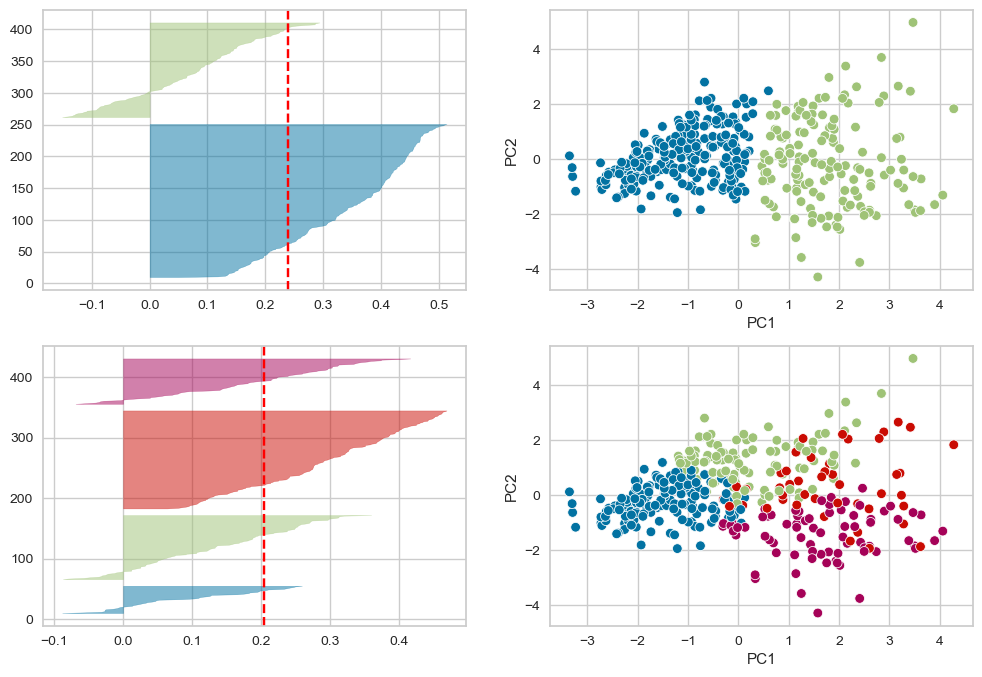

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

km_2 = KMeans(n_clusters=2)
visualizer = SilhouetteVisualizer(km_2, ax=axs[0, 0], colors='yellowbrick')
visualizer.fit(diabetes_stand_df[column_list].values)

plot_cluster_points(diabetes_stand_df, km_2.labels_ , 
        hue=list(map(lambda x: sns.color_palette().as_hex()[x], km_2.labels_)), legend=False, ax=axs[0, 1])

km_4 = KMeans(n_clusters=4)
visualizer = SilhouetteVisualizer(km_4, ax=axs[1, 0], colors='yellowbrick')
visualizer.fit(diabetes_stand_df[column_list].values)

plot_cluster_points(diabetes_stand_df, km_4.labels_, 
        hue=list(map(lambda x: sns.color_palette().as_hex()[x], km_4.labels_)), legend=False, ax=axs[1, 1])    

### DBSCAN

Para o DBSCAN a escolha do número ótimo de clusters é contra intuitivo, pois o algoritmo não é orientado ao número de centroides e sim aos parametros de distancia entre pontos e numero mínimo de pontos em um cluster. Assim sendo, o número ideal de cluster não existe, mas sim o número de clusters possível dentro dos parametros fornecidos atráves dos dados existentes. Logo utilizando os parametros padrões disponíveis pela biblioteca, a clusterização foi feita abaixo:

In [235]:
from sklearn.cluster import DBSCAN
dbscan =  DBSCAN(eps=2.4, min_samples=10)
dbscan_labels = dbscan.fit_predict(diabetes_stand_df[column_list])
diabetes_stand_df['dbscan_clusters'] = dbscan_labels
print(diabetes_stand_df['dbscan_clusters'].unique())


0.3725298153644127

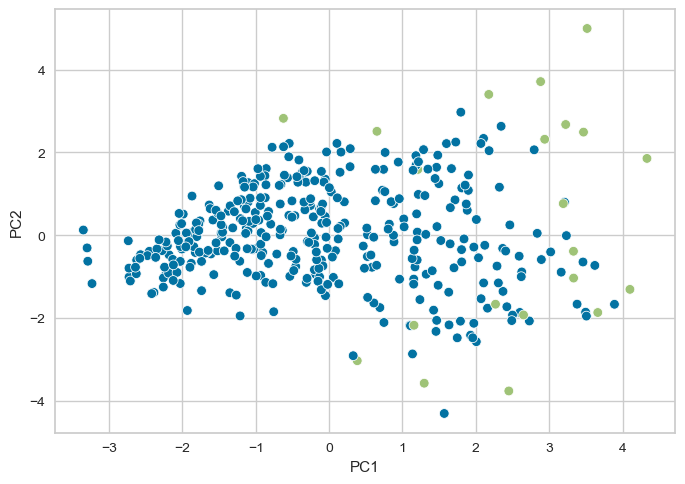

In [239]:
plot_cluster_points(diabetes_stand_df, diabetes_stand_df['dbscan_clusters'].values , 
        hue=list(map(lambda x: sns.color_palette().as_hex()[x], diabetes_stand_df['dbscan_clusters'].values)), legend=False)
metrics.silhouette_score(diabetes_stand_df[column_list],labels=diabetes_stand_df['dbscan_clusters'])

O coeficiente da silhueta é um método que valida cada ponto de um cluster em relação a distancia deste para
seu centroíde com a distancia deste para um ponto em outro cluster, com isso gerando uma normalização que
varia entre -1 e 1, sendo -1 uma associação errada, 0 uma associação confusa que ocorre normalmente na fronteira entre clusters e 1 que é a associação ideal.
![The San Juan Mountains are beautiful!](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTDm8pzN-MfwE0yqfHsw2cwEhQTuvcMdLRCIQ&usqp=CAU "San Juan Mountains")


Os resultados da clusterização mostraram-se menos favoráveis ao Kmeans com 4 clusters, afinal os dados categorizam quem possui ou não diabetes, entretanto a elevação dos clusters não gerou uma graduação linear capaz de delinear as regiões de fronteira, provavelmente a clusterização hierárquica seja capaz de apresentar melhor essas regiões de confusão, ainda sobre a região de confusão, no caso de dois cluster a cardinalidade apresenta-se baixa, somando isso, ao fato do cluster de menor quantidade ainda possuir dados com coeficiente negativo. 

Ja o DBSCAN apresentou um coeficiente de silhueta maior que ambos os casos do Kmeans, entretanto é notável que tal medição é insuficiente para indicar qualquer qualidade do modelo, pois a unica segregação feita foi de 1 cluster e ruído, inclusive para alcançar este resultado os parametros de distância e número mínimo de pontos por cluster tiveram de ser extraplolados dos valores padrões da função. Isto resulta em dois questionamentos:

> 1. Por que o coeficiente apresentou um resultado superior, mesmo possuindo uma clusterização de qualidade inferior?

> 2. Que outra medida de validação poderia ser usada para indicar a inferioridade do método diante do problema proposto?


O Coeficienta da silhueta é método orientado ao centroide de forma parecida com o kmeans, onde o centroide e suas distancias entre pontos são ponderadas para os diversos cálculos usados para sua composição, entretando o método Dbscan é orientado aos pontos, onde um numéro n de pontos a uma distancia y entre eles é o suficiente para formar um cetroide, logo centroides são criados de acordo com a esparcialidade dos dados, mas como o algoritmo criou apenas um cluster, a maior parte dos dados está a mais proximo do seus cluster do que o cluster que não existe, logo a silhueta não é o método mais indicado para avaliar a qualidade de clusterização do método DBSCAN, ainda pior é comparar com um método orientado ao cluster como o Kmeans.

---
<figure>
    <img src="conex_cluster.png"
         alt="Albuquerque, New Mexico">
    <figcaption>Os pontos nas extremidados do cluster tendem a ficar mais proximos do centroide do cluster oposto, um outro possível problema ao utilziar a silhueta em clusters criados por DBSCAN.</figcaption>
</figure><figure>


Verificaremos outras duas medidas de validação, com o objetivo de demostrar que a clusterização do dbscan é de fato inferior a do kmeans.
- A cardinalidade é usada para verificar se a distribuição de dados por cluster está equilibrada, o que é um sinal que algo deve ser verificado quando o mesmo não acontece.
- O DBCV é uma validação baseada na densidade dos clusters, verificando a densidade destes, a densidade entre clusters, retornando um valor nomalizado entre -1 a 1, que de forma parecida com a silhueta -1 é o pior resultado e 1 o melhor.

### Cardinalidade

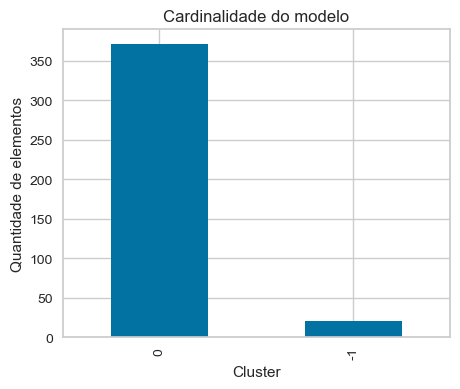

In [242]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
diabetes_stand_df['dbscan_clusters'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Cardinalidade do modelo')
ax.set_xlabel('Cluster')
ax.set_ylabel('Quantidade de elementos');

### DBCV

In [249]:
from DBCV import DBCV
from scipy.spatial.distance import euclidean
dbscan_score = DBCV(diabetes_stand_df[column_list].values, diabetes_stand_df.dbscan_clusters, dist_function=euclidean)
print(dbscan_score)

-0.1887734738937556


Com ambos os parametros, é possível verificar que a clusterização do DBSCAN apresenta uma qualidade aquém do desejado. É importante enfatizar que o resultado abaixo da-se pela forma que os dados se distribuem, a qual não é a mais indicada de ser abordada pelo algoritmo, assim sendo não ja limpeza ou preprocessamento que mude a natureza do mesmo.

# Série Temporal

Considerando que tenhamos um quantidade n de séries temporais, para agrupar-las em 3 cluster, necessitamos efetuar os seguintes passos:
1. É necessario carregar os dados em memória, isso pode ser feito através do pandas, dependendo do formato que os dados se encontram.
2. Faz-se necessário pre-processarlos, isso inclui remoção de outliers, valores nulos, valores inválidos, normalização, etc..
3. É necessário certificar que todas as series possuem o mesmo intervalo e range de tempo.
4. Aqui algumas opções estão disponíveis:
    - Calcular a correlação cruzada global, este desloca os valores de uma das séries no tempo e calcula a correlação desta com outra, returnando o valor máximo possível e o deslocamento necessário para o mesmo.
    - Calcular a correlação cruzada janelada, este ao inves de um único valor, diversas correlações são retornadas, uma para cada janela. O que torna possível visualizar a sazionalidade dos dados. 
   
Ambas retornarão uma matriz de correlação, que será usada como input do processo de clusterização.

Como o número de cluster é específico, a matriz gerada no passo anterior servirá de input para o algoritmo Kmeans, com o número de clusters setado para 3

Um uso comum para analise clusterizada de séries temporais é no mercado de ações. 
A clusterização por correlação indica um grupo ações de empresas que possuem comportamento similar ao longo do tempo e como essa correlação é defasada no tempo, temos a capacidade de previsão de comportamento de mercado, por exemplo:
A empresa Y do cluster bancário possui alta correlação com todos o cluster com uma defasagem de -3 horas, o que indica que o que acontece com essa ação historicamente tende a se replicada 3 horas depois por todas as outras empresas no cluster.